In [1]:
import io

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm


In [2]:
# number of 2D data points for forming the 'circle' distribution
num_samples = 10000

# read image from file as a binary numpy array
image = Image.open('circle.jpg')
image = image.convert('L')
image = np.array(image)

In [3]:
# circle.jpg is a binary image with black pixels as the circle and white pixels as the background
# find the min and max index that contain black pixels
min_x = np.min(np.where(image == 0)[0])
max_x = np.max(np.where(image == 0)[0])
min_y = np.min(np.where(image == 0)[1])
max_y = np.max(np.where(image == 0)[1])

# radius and the centre index of the circle
radius = (max_x - min_x) / 2
center_x = (max_x + min_x) / 2
center_y = (max_y + min_y) / 2

# create a label map that divide the circle into 3 regions (0, 1, 2), depending on the distance to the center
# 0: less or equal to 1/3 radius to the center, <= 1/3 radius
# 1: between 1/3 and 2/3 radius to the center, > 1/3 radius and <= 2/3 radius
# 2: more than 2/3 radius to the center, > 2/3 radius
label_map = np.zeros_like(image) - 1
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i, j] == 255:
            continue
        dist = np.sqrt((i - center_x) ** 2 + (j - center_y) ** 2)
        if dist <= radius / 3: # inner circle
            label_map[i, j] = 0
        elif dist <= 2 * radius / 3: # middle circle
            label_map[i, j] = 1
        else: # outer circle
            label_map[i, j] = 2

# random sample num_samples pixels from the image
data = np.argwhere(image == 0) # get all the indices of black pixels
data[:,0], data[:,1] = data[:,1], image.shape[0]-data[:,0] # swap the x and y axis

num_black_pixels = data.shape[0]

data = data[np.random.choice(num_black_pixels, num_samples, replace=False)]

# data is now a 2D numpy array with shape (num_samples, 2), each row is a pixel coordinate
labels = label_map[data[:,0], data[:,1]]

# normalize the data by subtracting the mean and dividing by the standard deviation
data = (data - data.mean(0)) / data.std(0)

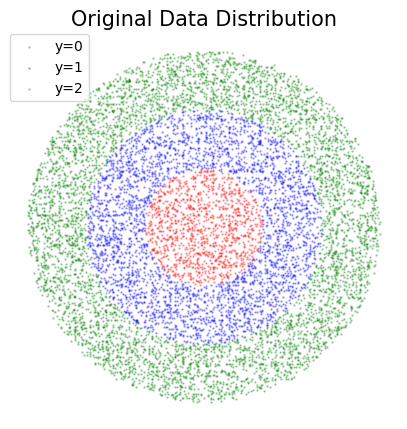

In [4]:
# to visualise the data, we need the shape of the image to be (2, num_samples)
curve = data.T

# initialize the figure
fig,ax = plt.subplots()
fig.set_size_inches(5,5)

# plot the scatter where label 0, 1, 2 are colored read, blue, green respectively
zeros = curve[:,(labels==0).reshape(-1)]
ones = curve[:,(labels==1).reshape(-1)]
twos = curve[:,(labels==2).reshape(-1)]

axs = ax.scatter(zeros[0,:], zeros[1,:], c='r',s=0.6, alpha=0.3, label='y=0')
axs = ax.scatter(ones[0,:], ones[1,:], c='b', s=0.6, alpha=0.3, label='y=1')
axs = ax.scatter(twos[0,:], twos[1,:], c='g', s=0.6, alpha=0.3, label='y=2')

ax.axis('off')
plt.legend(loc='upper left', borderaxespad=0.)
plt.title('Original Data Distribution', fontsize=15, color='black')
plt.show()

In [5]:
# a simple Dataset class for the circle dataset
class CircleDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    

In [6]:
# convert the data and labels to torch tensors
data = torch.Tensor(data).float()
labels = torch.Tensor(labels).long().view(-1, 1)

# create a dataset object
dataset = CircleDataset(data, labels)

In [7]:
# set values for beta, the variance list of the diffusion process
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

# we set the total number of steps to be 100, assuming noised image is like a standard Gaussian distribution in step 100
num_steps = 100

# set methods for beta, 'linear', 'quad', 'sigmoid' can be used
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

In [8]:
# Calculate alpha、alpha_prod、alpha_prod_previous、alpha_bar_sqrt
# they are used to calculate the variance of the diffusion process
alphas = 1-betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [9]:
# Forward q sample process, q(x_t|x_0), get x_t from x_0

# According to the provement, we can directly sample at any given timesteps (add noise)
# x[0] -> x[t]
def q_x(x_0,t):
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)


In [10]:
# show the results of forward process (when origin image add noise)
num_shows = 20

In [11]:

class MLPDiffusion(nn.Module):
    """Model for predicting the added noise epsilon based on the current noised image, time step and condition guidance

    Args:
        n_steps (int): is the number of steps in the diffusion process
        num_units (int): is the number of units in the hidden layers of the MLP
    """
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        # define the layers of the MLP for predicting epsilon
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        
        # define the 3 layers of the condition embedding, which will be inserted before the each 3 linear layers
        self.y_embeddings = nn.ModuleList(
            [
                nn.Embedding(3, num_units),
                nn.Embedding(3, num_units),
                nn.Embedding(3, num_units),
            ]
        )
        
        # define the 3 layers of the time embedding, which will be inserted before the each 3 linear layers, after the condition embedding
        self.t_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t, y=None, uncon_rate=0.1):
        """ 生成的过程: 把t的值作为一个embedding,然后和x相加
        下边的循环等价于把每个nn.Embedding分别插入到每个nn.Linear之前
        CONDITIONAL: (FC -> +=y_embedding -> +=t_embedding -> ReLU) * 3 -> FC
        UNCONDITIONAL: (FC -> +=t_embedding -> ReLU) * 3 -> FC
        """
        # uncon_rate probability, we add the embedding of y and t to x
        unconditional = torch.rand(1) <= uncon_rate
        
        for idx in range(len(self.y_embeddings)):
            x = self.linears[2 * idx](x) # linear layer
            # with 10% probability, we add the embedding of y and t to x
            if not unconditional and y is not None:
                y = y.reshape(-1) # reshape y to 1D
                y_embedding = self.y_embeddings[idx](y) # get the condition embedding of y
                x += y_embedding # add the condition embedding of y to x
            
            t_embedding = self.t_embeddings[idx](t) # get the time step embedding of t
            x += t_embedding # add the time step embedding of t to x
            x = self.linears[2 * idx + 1](x) # ReLU

        # final linear layer
        x = self.linears[-1](x)

        return x

In [12]:
# sampling process, get x_0 from x_t, p(x_0|x_t)
def p_sample(model, x, y, t, betas, one_minus_alphas_bar_sqrt, w = 3.0):
    """from x[T] sampling"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = (1 + w) * model(x, t, y, uncon_rate=0.0) - w * model(x, t, uncon_rate=1.0)

    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    # sample from the distribution above
    sample = mean + sigma_t * z

    return (sample)

# get x_0 from x_t, p(x_0|x_t) by iteratively sampling from p(x_t|x_0), p(x_t-1|x_t), ..., p(x_0|x_1)
def p_sample_loop(model, y, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """from x[T] to x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, y, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

In [13]:
# loss function
def diffusion_loss_fn(model, x_0, y, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """
    choose a random t and sample from p(x_t|x_0) using epsilon e, and estimate e using the model
    loss is the mean squared error between the sampled epsilon and the estimated epsilon
    """
    
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t
    # get batch_size // 2 random time steps
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    # get the other half of the time steps by mirroring the first half
    t = torch.cat([t, n_steps - 1 - t], dim=0)
    # reshape t to (batch_size, 1)
    t = t.unsqueeze(-1)

    # x0的系数
    # get the coefficient of x_0
    a = alphas_bar_sqrt[t]

    # eps的系数
    # get the coefficient of epsilon
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    # generate random noise epsilon for sampling x_t
    e = torch.randn_like(x_0)

    # 构造模型的输入
    # x_t = x_0 * a + e * aml by p(x_t|x_0)
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    # get the predicted epsilon by the model with x_t and t and condition y with 10% probability for CFG
    output = model(x, t.squeeze(-1), y, uncon_rate=0.1)

    # 与真实噪声一起计算误差，求平均值
    # loss is the mean squared error between the sampled epsilon and the estimated epsilon
    return (e - output).square().mean()

Training model...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.8710


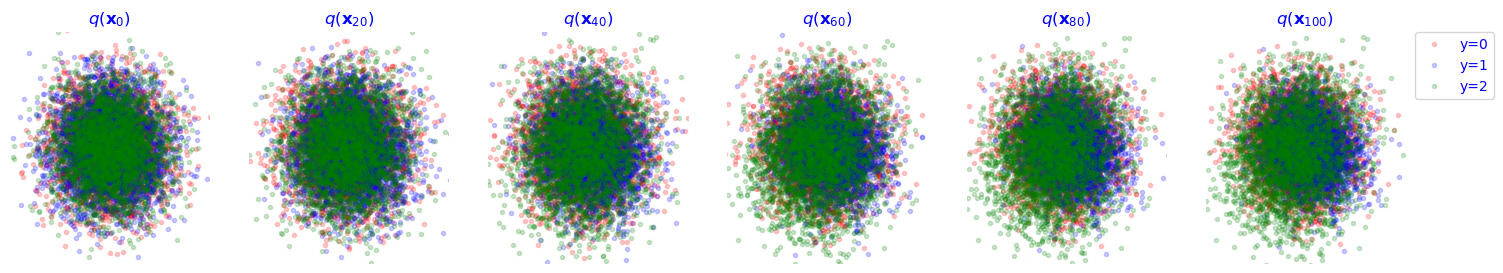

  5%|▌         | 200/4000 [00:28<07:56,  7.97it/s]

Epoch: 200, Loss: 0.9049


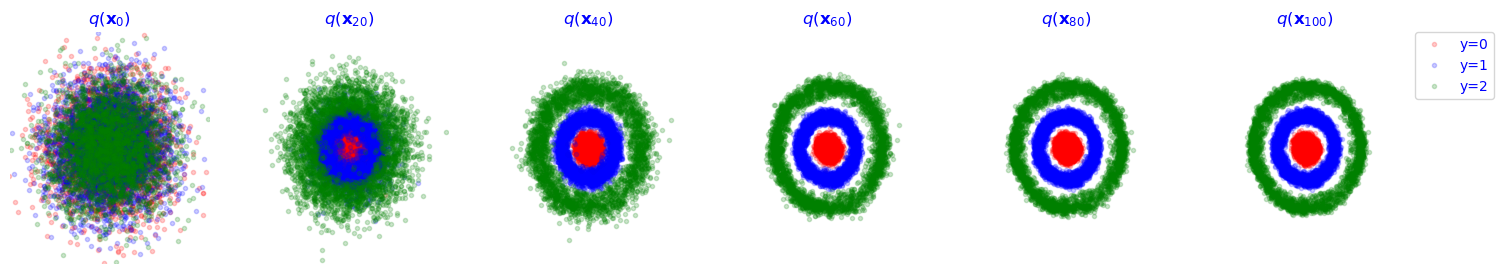

 10%|█         | 400/4000 [00:57<07:29,  8.01it/s]

Epoch: 400, Loss: 0.5886


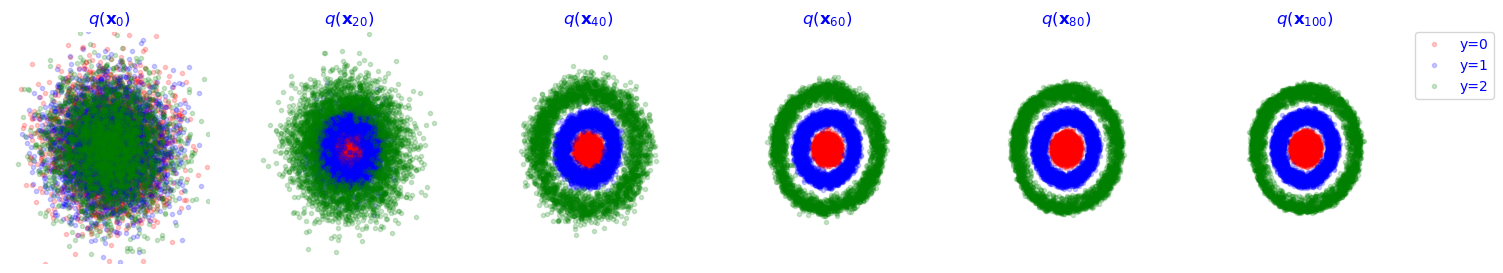

 15%|█▌        | 600/4000 [01:25<07:06,  7.97it/s]

Epoch: 600, Loss: 0.6620


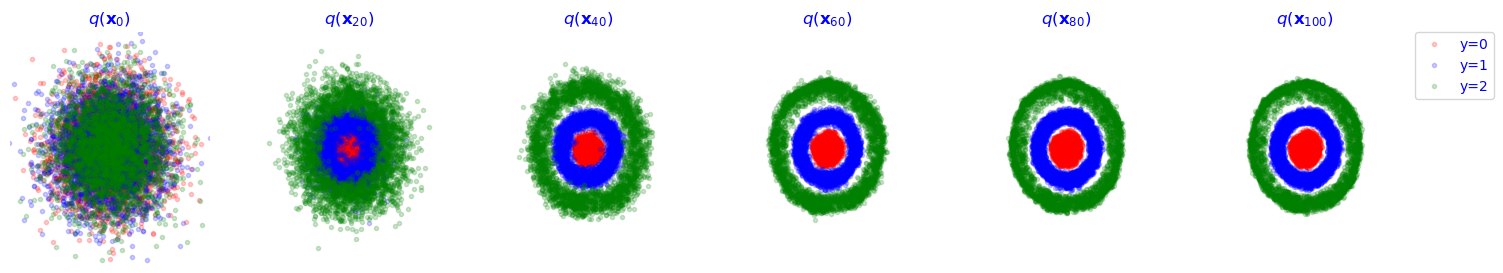

 20%|██        | 800/4000 [01:53<06:45,  7.90it/s]

Epoch: 800, Loss: 0.4926


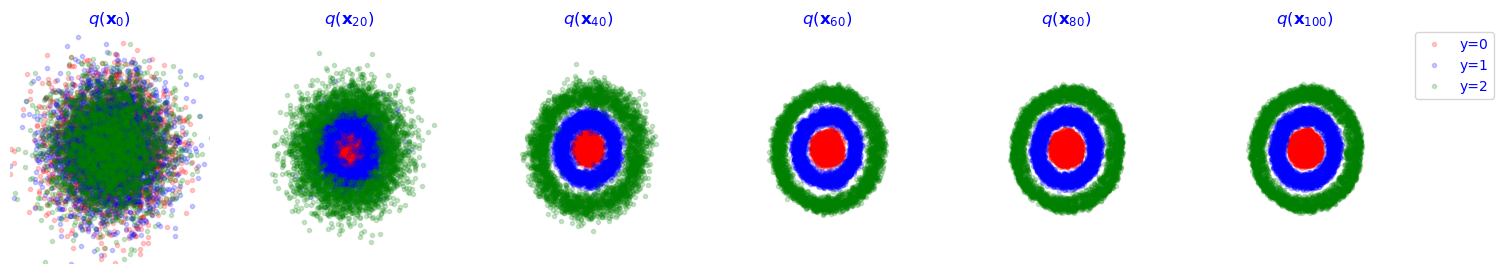

 25%|██▌       | 1000/4000 [02:22<06:42,  7.45it/s]

Epoch: 1000, Loss: 0.7976


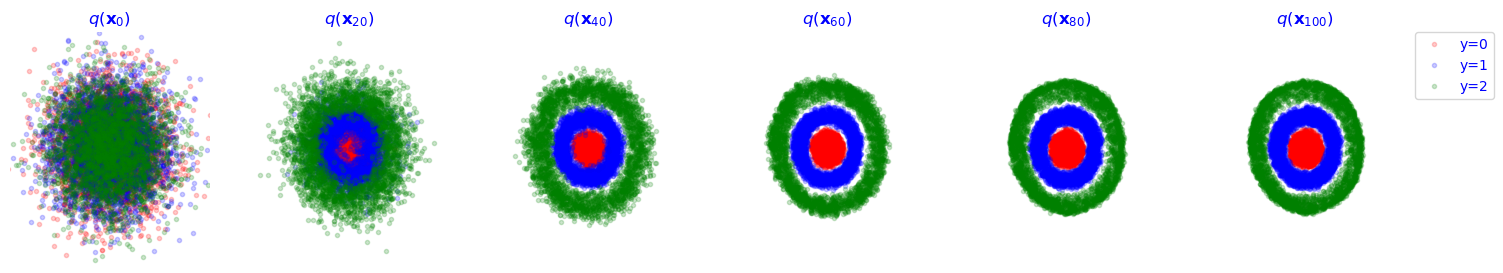

 30%|███       | 1200/4000 [02:51<05:55,  7.88it/s]

Epoch: 1200, Loss: 0.8009


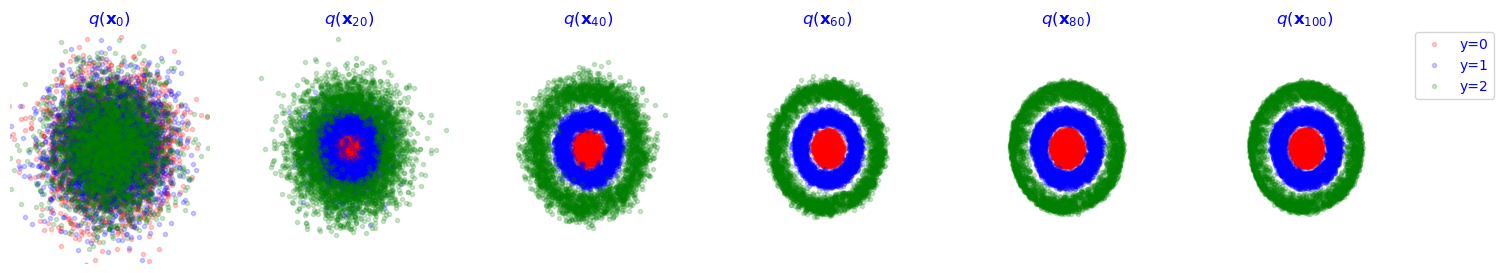

 35%|███▌      | 1400/4000 [03:18<05:23,  8.04it/s]

Epoch: 1400, Loss: 0.9546


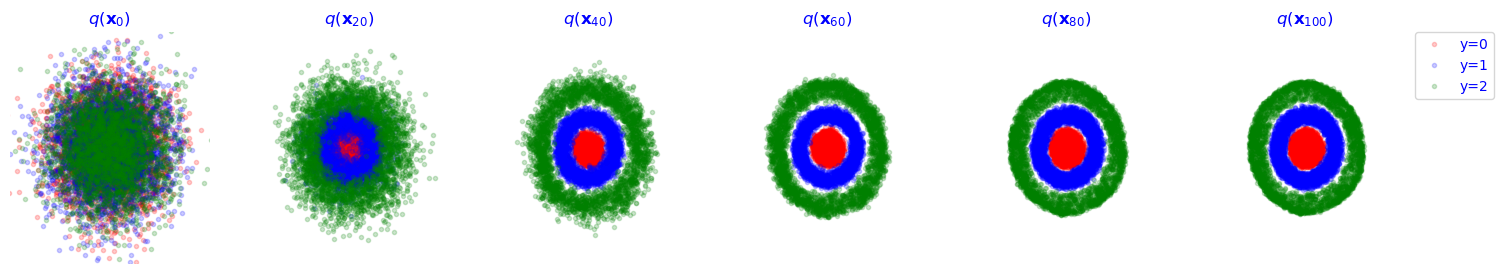

 40%|████      | 1600/4000 [03:48<05:44,  6.96it/s]

Epoch: 1600, Loss: 0.5834


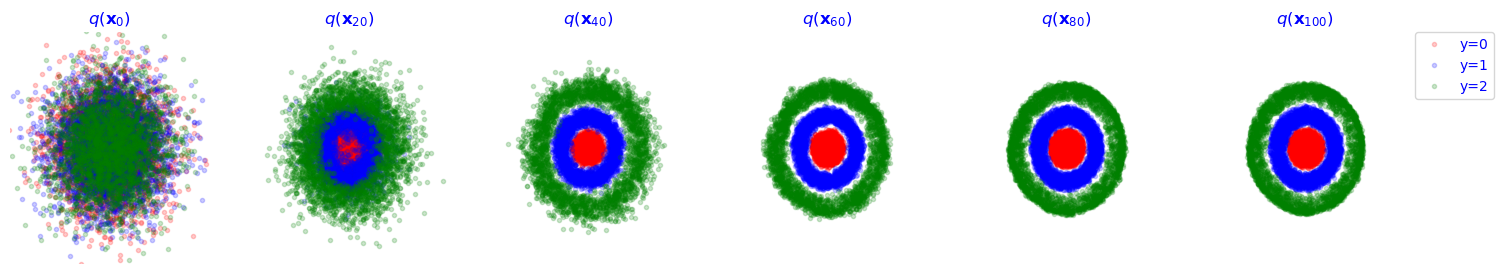

 45%|████▌     | 1800/4000 [04:17<04:37,  7.93it/s]

Epoch: 1800, Loss: 0.4538


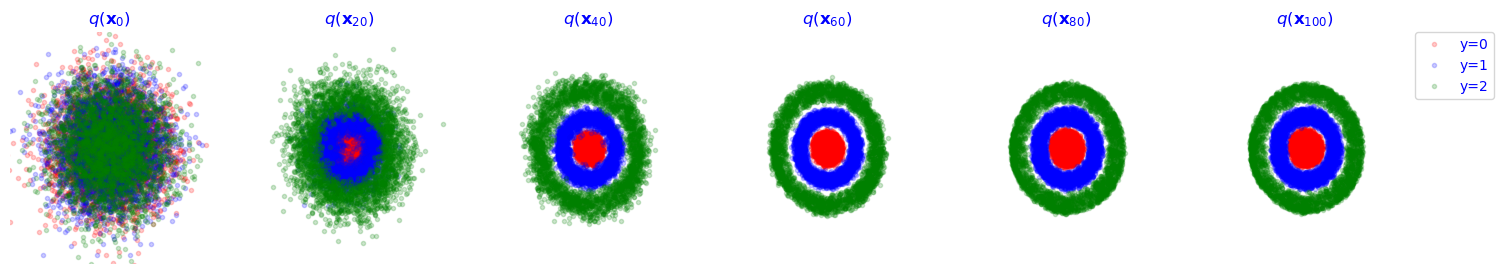

 50%|█████     | 2000/4000 [04:45<04:09,  8.03it/s]

Epoch: 2000, Loss: 0.7640


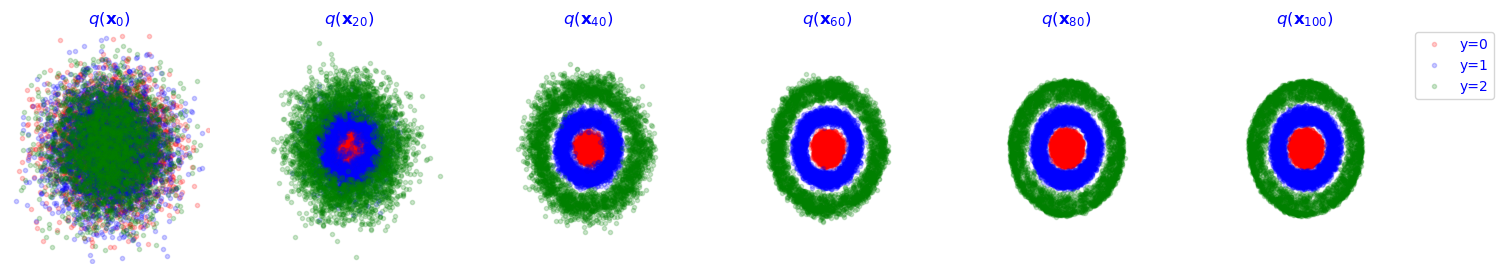

 55%|█████▌    | 2200/4000 [05:13<03:42,  8.08it/s]

Epoch: 2200, Loss: 0.5515


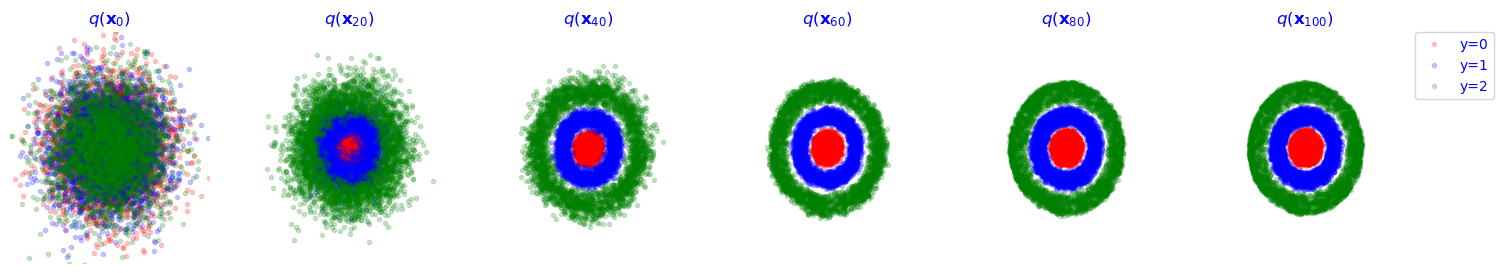

 60%|██████    | 2400/4000 [05:40<03:17,  8.10it/s]

Epoch: 2400, Loss: 0.7222


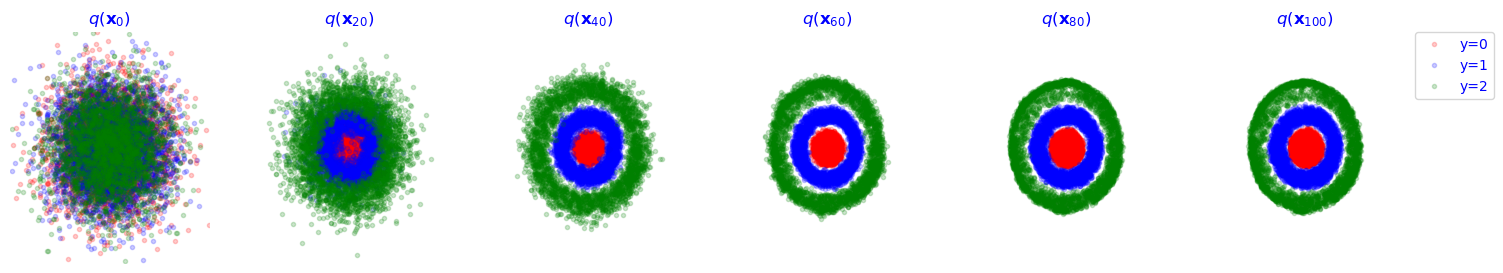

 65%|██████▌   | 2600/4000 [06:08<02:55,  7.98it/s]

Epoch: 2600, Loss: 1.0859


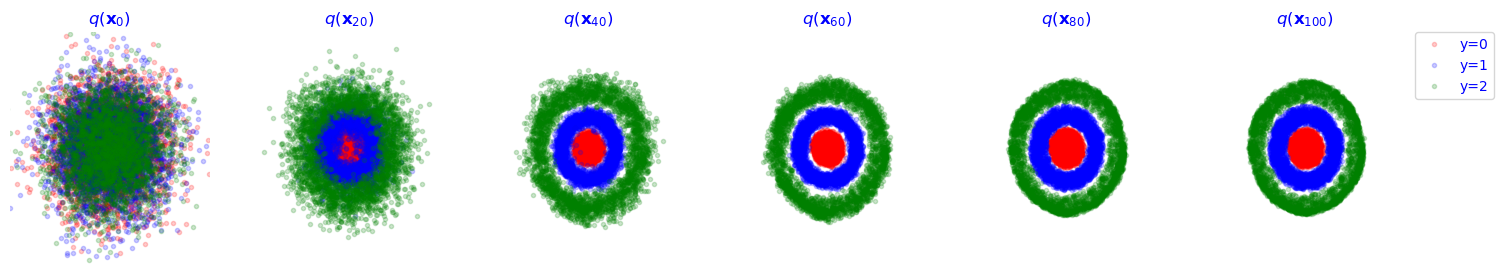

 70%|███████   | 2800/4000 [06:35<02:30,  7.98it/s]

Epoch: 2800, Loss: 0.6925


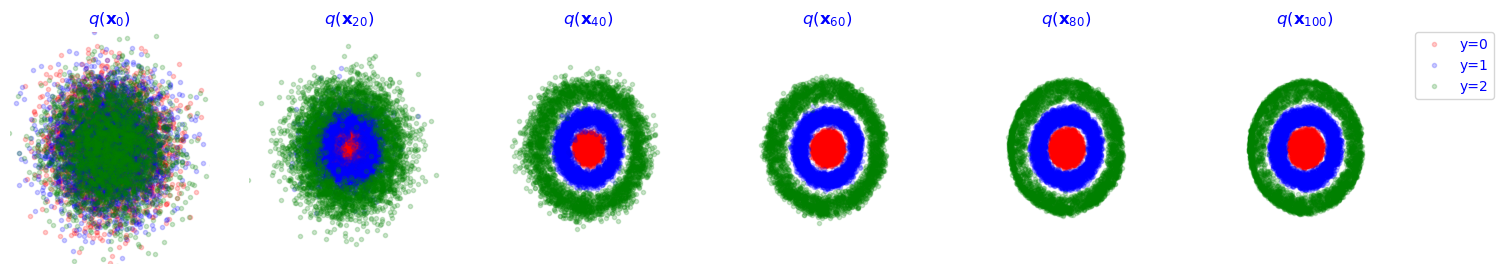

 75%|███████▌  | 3000/4000 [07:02<02:03,  8.07it/s]

Epoch: 3000, Loss: 0.7306


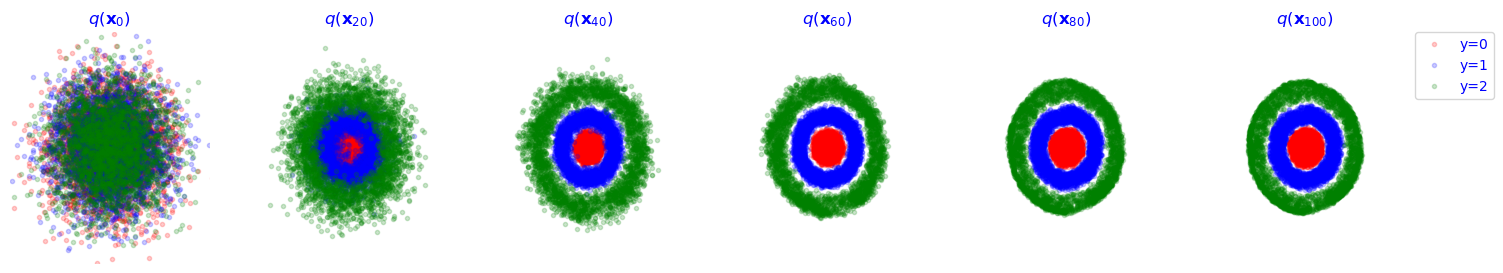

 80%|████████  | 3200/4000 [07:30<01:38,  8.09it/s]

Epoch: 3200, Loss: 0.9347


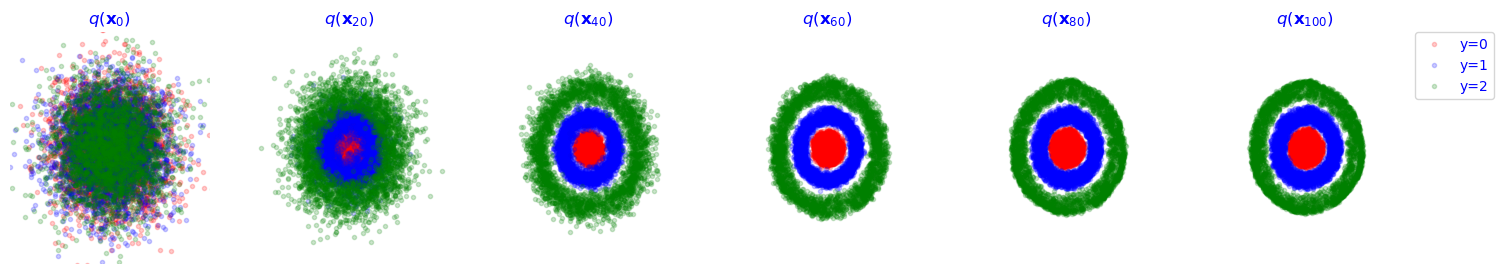

 85%|████████▌ | 3400/4000 [07:57<01:14,  8.02it/s]

Epoch: 3400, Loss: 0.6071


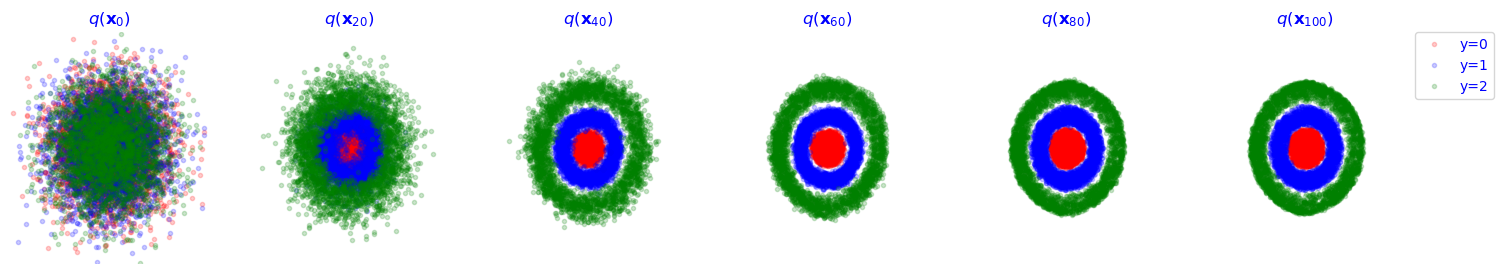

 90%|█████████ | 3600/4000 [08:25<00:50,  7.95it/s]

Epoch: 3600, Loss: 1.1251


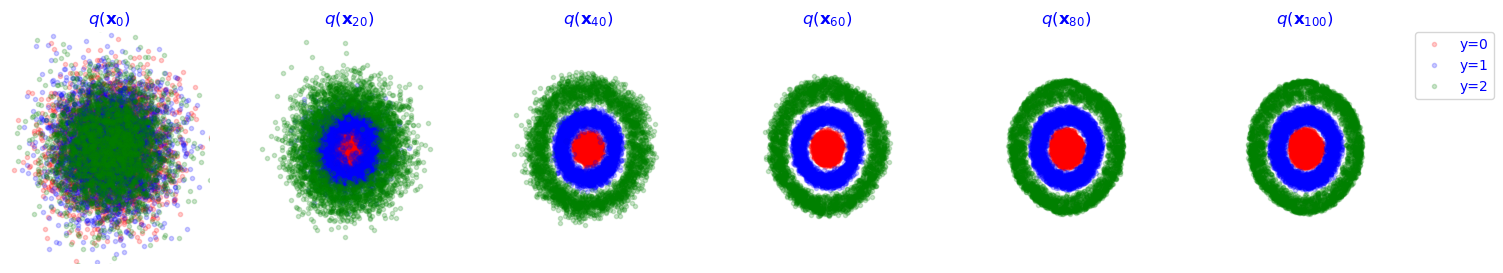

 95%|█████████▌| 3800/4000 [08:52<00:25,  8.00it/s]

Epoch: 3800, Loss: 0.9145


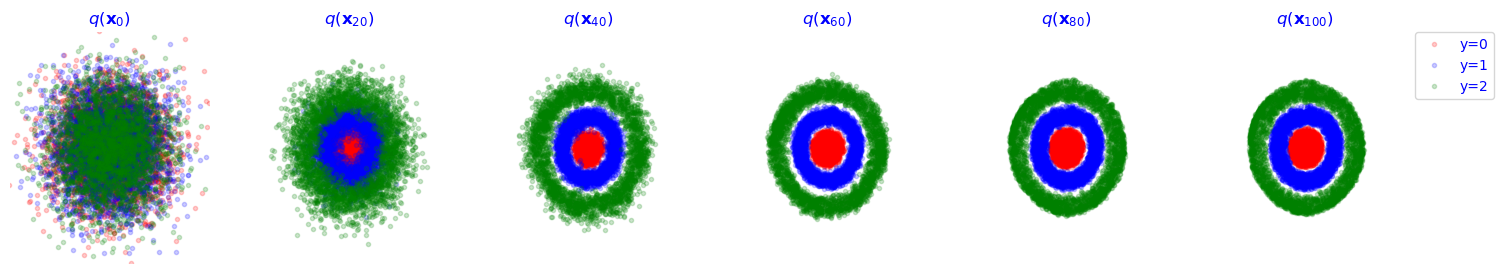

100%|██████████| 4000/4000 [09:19<00:00,  7.14it/s]


In [14]:
# Training model
seed = 1234

print('Training model...')


batch_size = 128
num_epoch = 4000
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps)  # output_dim = 2 as our data have 2 dimensions
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in tqdm(range(num_epoch)):
    for idx, (batch_x, batch_y) in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, batch_y, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()


    # print loss and sampling process
    if (t % 200 == 0):
        tqdm.write('Epoch: {}, Loss: {:.4f}'.format(t, loss.item()))
        # random choose 0 or 1 
        y0 = torch.tensor([0])
        y1 = torch.tensor([1])
        y2 = torch.tensor([2])
        shape = (data.shape[0]//3, data.shape[1])
        x_seq0 = p_sample_loop(model, y0, shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        x_seq1 = p_sample_loop(model, y1, shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        x_seq2 = p_sample_loop(model, y2, shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        
        fig, axs = plt.subplots(1, 6, figsize=(18, 3))
        scatter_range = [-3.5, 3.5]
        for i in range(0, 6):
            cur_x0 = x_seq0[i * 20].detach()
            cur_x1 = x_seq1[i * 20].detach()
            cur_x2 = x_seq2[i * 20].detach()
            # plot on the same scatter figure with different color
            axs[i].plot(cur_x0[:, 0], cur_x0[:, 1], '.', color='red',alpha=0.2, label='y=0')
            axs[i].plot(cur_x1[:, 0], cur_x1[:, 1], '.', color='blue',alpha=0.2, label='y=1')
            axs[i].plot(cur_x2[:, 0], cur_x2[:, 1], '.', color='green',alpha=0.2, label='y=2')
            # set the range of the scatter figure
            axs[i].set_xlim(scatter_range)
            axs[i].set_ylim(scatter_range)
            axs[i].set_axis_off();
            axs[i].set_title('$q(\mathbf{x}_{' + str(i * 20) + '})$')
        # fix the legend position
        axs[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.show()

In [16]:
%%capture
# Generating the forward image sequence.
imgs = []
# Generating the reserve diffusion sequense
for i in range(100):
    plt.clf()
    plt.figure(figsize=(6, 6))
    scatter_range = [-2.5, 2.5]
    cur_x0 = x_seq0[i].detach()
    cur_x1 = x_seq1[i].detach()
    cur_x2 = x_seq2[i].detach()
    plt.plot(cur_x0[:, 0], cur_x0[:, 1], '.', color='red',alpha=0.3, label='y=0')
    plt.plot(cur_x1[:, 0], cur_x1[:, 1], '.', color='blue',alpha=0.3, label='y=1')
    plt.plot(cur_x2[:, 0], cur_x2[:, 1], '.', color='green',alpha=0.3, label='y=2')
    plt.xlim(scatter_range)
    plt.ylim(scatter_range)
    plt.legend(loc='upper left', borderaxespad=0.)
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='jpg', bbox_inches='tight')
    img = Image.open(img_buf)
    imgs.append(img)

imgs[0].save("cfg_ddpm.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0,border=0)

This gif shows the progress of how the picture into noise, and then reserve.  
![output](cfg_ddpm.gif)